*data visualisation notes * 
part 1 : some simple clinical data from ....

I would suggest essential reading prior to this is : 
https://matplotlib.org/tutorials/introductory/usage.html

Which gives an excellent overview of the matplotlib OO environment

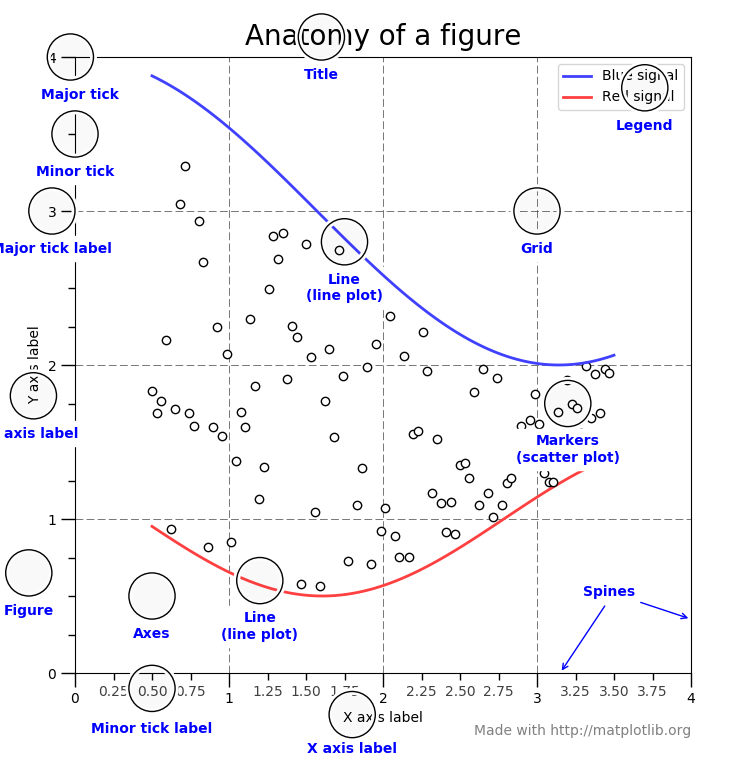

In [1]:
import os
import pandas as pd
import numpy as np
import ipywidgets as widgets

tt = os.getcwd()
print('this is your working directory - change if necssary using chdir: ',tt)
os.chdir('.\\walkingsignals\\walkingsignals')


this is your working directory - change if necssary using chdir:  C:\Users\telferm


In [ ]:
%qtconsole # if you run this cell, you will get a console up that gives you access to this python kernal
# this allows you to enter commands outside of the noteook, maybe to check the value of a variable or check that a command
# or function has the correct syntax without having to run the whole cell ... very useful ! 

In [2]:
# note prior to loading, changed almost fallen entries in original data as follows:
# once a week = 52, once a month = 12 , 2-3 week 125, more than 12 - 20.
# others non-numeric entries changed to na 
fn =  '.\\data\\weiss\\ClinicalDemogData_FL.csv'
fn2 = '.\\data\\weiss\\ClinicalDemogData_CO.csv'
df = pd.read_csv(fn,header=0,na_values=['n/a','N/A ','na'])
df2 = pd.read_csv(fn2,header=0,na_values=['n/a','N/A ','na'])
df3 = pd.concat([df,df2],axis=0)
# should have dataframe that is 77x30 
df3.shape

(77, 30)

get the data into shape 

In [3]:

#from this we can see the Gender cols are not named the same 
#copy  gender(1-male , 0 female ) to the other column 
df3.rename(columns={'Gender(0-male,1-female)':'Gender'},inplace=True)
df3.rename(columns={'Gender(1-female, 0-male)':'GenderX'},inplace=True)
df3.Gender = df3.apply(lambda x: x.GenderX if pd.isnull(x.Gender) \
                             else x.Gender,axis=1 ) 
#assert genderx = null or gender
df3.drop(['GenderX'],inplace=True,axis=1)

# rename > 1 at once 
recol = {' yr almost':'fall_almost','6 Months Fall':'fall_6',
         'Year Fall ':'fall_year',
         'base(velocity)':'v_base',
         's3(velocity)':'v_s3',
         '#':'faller',
         'EFI (Exe. Func. Index)':'EFI'}

df3.columns
df3.rename(columns=recol,inplace=True)
# force cols to numeric (all non-numeric entries will be replaced with na )
df3.fall_almost = df3.fall_almost.apply(lambda x: pd.to_numeric(x,errors='coerce'))
df3.fall_year = df3.fall_year.apply(lambda x: pd.to_numeric(x,errors='coerce'))
df3.fall_6 = df3.fall_6.apply(lambda x: pd.to_numeric(x,errors='coerce'))

# check out the index - let's fix that ! 
#TODO show dupes in index somehow
df3.set_index(np.arange(df3.shape[0]),inplace=True) # reset index - has dupes at the mo 
# make  faller col (currently FL-nnn) an indicator rather than text

df3.faller = df3.faller.apply(lambda x:  1 if x[0:2]=='FL' else 0)
 
#take numeric only and fillna with  median of column 
df4 = df3.select_dtypes(include=[np.number])
df4.isnull().sum()
df4 = df4.fillna(df4.median())


Do some box plots 

In [13]:
#box and whisker of all numerics
#TODO is pyplot still current?
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed
from IPython import display

#It would be good to scale these features too ... you'll see why 

%matplotlib inline

#TODO - bug in showing scaled output for demographics 
def tt(featureset,scaled):
    # PULL APPRoPRIaTE FEATURE SET 
    
    if featureset == 'topfeatures':
        print(featureset)
        selectedDf = df4.drop(['fall_almost','fall_6','fall_year','DGI stairs','v_s3',
                        'tandem_eyes_open','feet close eyes open','TMTa','TMTb','MoCa','GCS (Neurotrax)','EFI','faller',
                        'Gender','PASE'],axis=1)
    elif featureset == 'Neuro related':
        print(featureset)
        selectedDf = df4[['fall_almost','fall_6','fall_year','DGI stairs','v_s3',
                    'tandem_eyes_open','feet close eyes open','TMTa','TMTb','MoCa','GCS (Neurotrax)','EFI','faller',
                    'Gender','PASE']]
    elif featureset == 'demographics':
        print(featureset)
        selectedDf = df4[['fall_almost','fall_6','fall_year','Age','Gender','faller',
                    'Gender','PASE']]
    else: 
        selectedDf = df4
        print('else',featureset)
        
    if scaled: # scale the output
        df4scaled=selectedDf.copy()
        df4scaled=df4scaled-df4scaled.min() # how do you get back to real ages/scores ? 
        # thats where scikit learn transformers are useful - you can transfor back as and when
        df4scaled= df4scaled/df4scaled.max() # rescale to 0-1
        selectedDf = df4scaled.copy()
    

        
        
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111) # get n axis associated with the figure 
    selectedDf.plot.box(ax=ax,rot=45)
    plt.show()
    #plt.gcf().show()
    #display.clear_output(wait=True)


featureset = widgets.RadioButtons(
    options=['topfeatures', 'Neuro related', 'demographics'],

    description='Feature Sets:',
    disabled=False
)

scaled = widgets.ToggleButton(
    value=False,
    description='ReScale',
    disabled=False,
    button_style='danger', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='click to toggle scale',
    icon='check'
)


interact(tt, featureset=featureset,scaled=scaled);

Draw a scatterplot for all-vs-all plots and distribution 

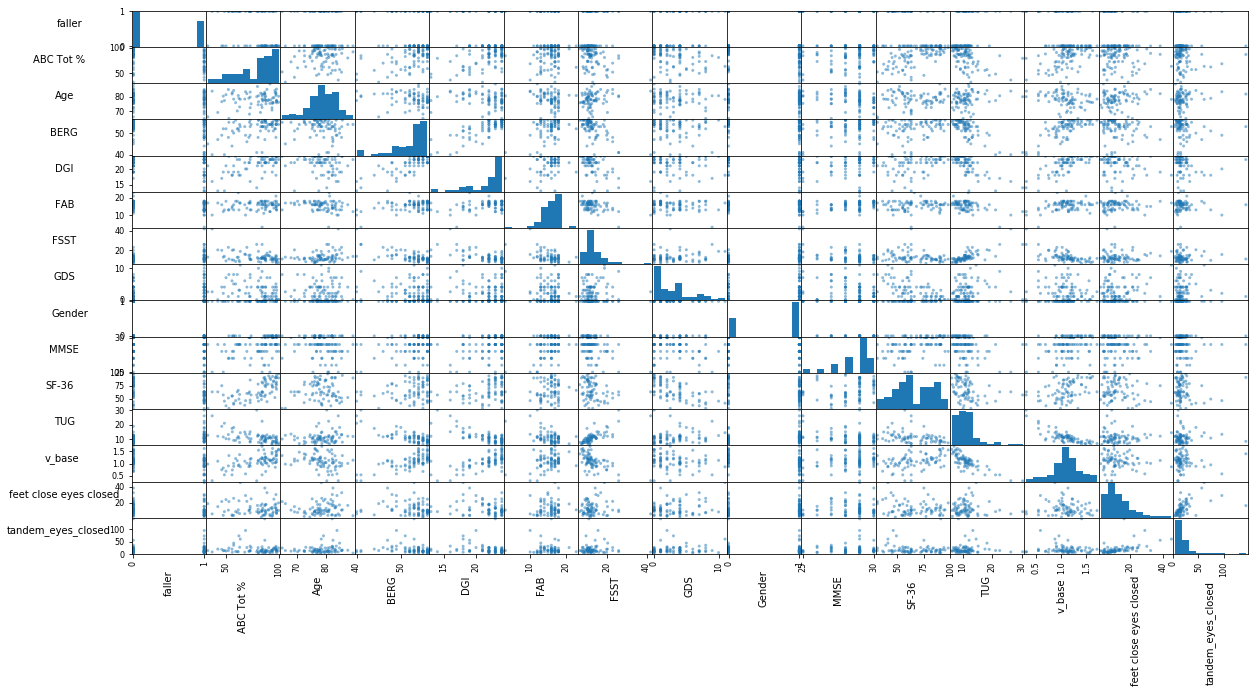

In [14]:
# from this point on we will use the reduced dataset of balance related and demographic datapoints - only the SF-36, MMSE and 
# FAB remain from the neuro tests 
miniDf = df4.drop(['fall_almost','fall_6','fall_year','DGI stairs','v_s3',
                'tandem_eyes_open','feet close eyes open','TMTa','TMTb','MoCa','GCS (Neurotrax)','EFI','PASE'],axis=1)

miniDf.to_csv('miniDf.scv')
from pandas.plotting import scatter_matrix

axs = scatter_matrix(miniDf,figsize=(20,10)) # need  the axis to rotate the labels 
# wow - that's big ... is it informative ? top right and bottom left 
# seem to be worth looking at 

axs.shape
type(axs[1,1])
# for each pair of axes in array, set the label 
for row in axs:
    for ax in row:
            # to make x axis name vertical  
        ax.xaxis.label.set_rotation(90)
        # to make y axis name horizontal 
        ax.yaxis.label.set_rotation(0)
        # to make sure y axis names are outside the plot area
        ax.yaxis.labelpad = 50
        
plt.show()



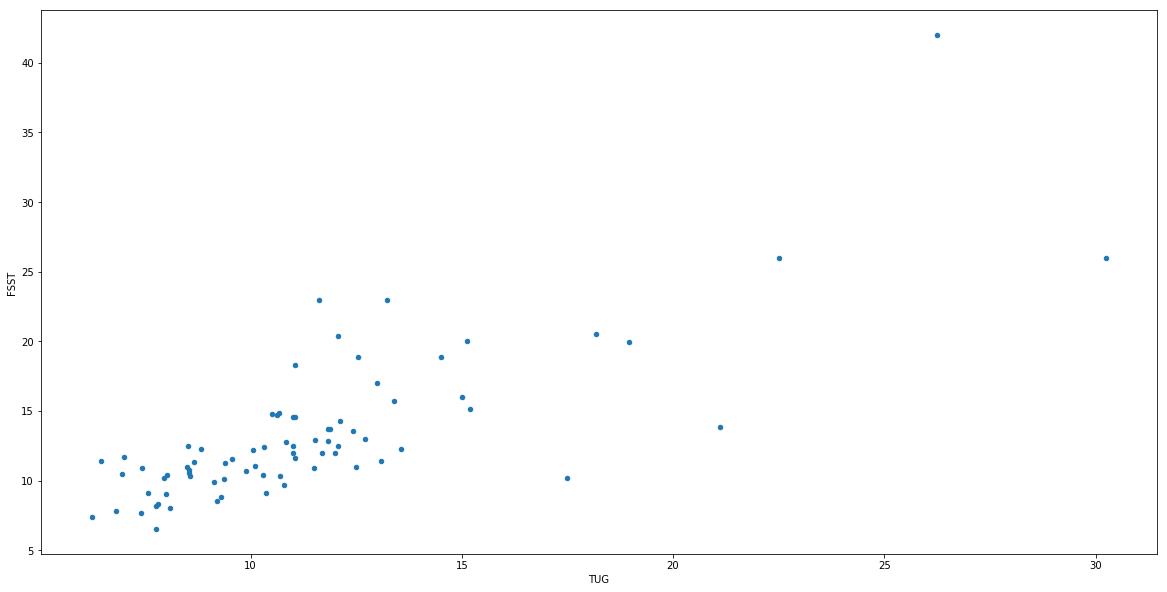

In [22]:
# are tug and fsst correlated ? (could put correlation coefficients in each square  ) 
# tug is timed up and go ... timing how long it taes to stand up from seated, walk, turn, sit down again 
# fsst is 4 square step test - how nimble you are stepping between four squares 
# scatter tug and fsst as example: 
miniDf.plot.scatter(x='TUG',y='FSST',figsize=(20,10))
# we can add regression lines and color each spot indicating age , for example 


(5, 30.25)

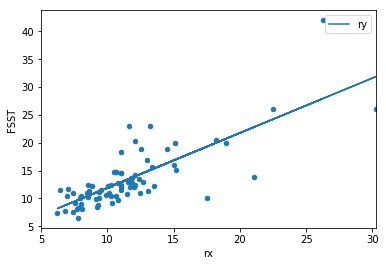

In [23]:
# add regression line http://stamfordresearch.com/linear-regression-using-pandas-python/

lm_original = np.polyfit(miniDf.TUG, miniDf.FSST, 1)
 
# calculate the y values based on the co-efficients from the model - better explain the python here ! 

r_x, r_y = zip(*((i, i*lm_original[0] + lm_original[1]) for i in miniDf.TUG))
 
# Put in to a data frame, to keep is all nice
lr = pd.DataFrame({
'rx' : r_x,
'ry' : r_y
})
# plot it - get some axes to plot on and a figure to put the axes in:
fig, ax = plt.subplots()
# scatter plot followed by lr plot 
miniDf.plot.scatter(x='TUG',y='FSST',ax=ax)
lr.plot.line(x='rx',y='ry',ax=ax)
ax.set_xlim([5,lr.rx.max()])
          





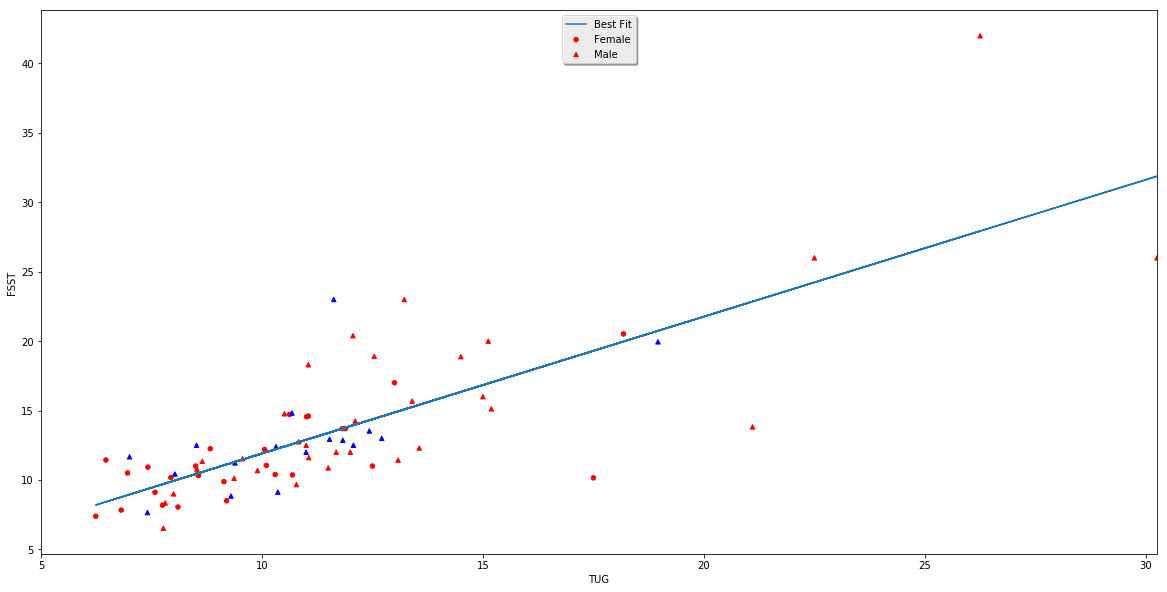

In [24]:
# now lets colour the spots by faller and give gender a different shape 
# minidf fallers can be red, others blue 
col = miniDf.faller.map(lambda x: 'blue' if x==0 else 'red') # create a series of 'red and 'blue'
marker = miniDf.Gender.map(lambda x: 'o' if x==0 else '^') 
fig, ax = plt.subplots(figsize=(20,10))
# scatter plot followed by lr plot
marks = {0:'o',1:'^'}
lab=['Female','Male'] # labels for each plot - these are for the Legend 

for val,mark in marks.items(): 
    # need to calculate the colour array as we are now splitting the dataset in 2 to allow us to assign different markers 
    miniDf[miniDf.Gender==val].faller.map(lambda x: 'blue' if x==0 else 'red')
    miniDf[miniDf.Gender==val].plot.scatter(x='TUG',y='FSST',ax=ax,c=col,marker=mark, label=lab[val])
# plt.scatter([], [], ' ', label="Extra label on the legend")
lr.plot.line(x='rx',y='ry',ax=ax,label='Best Fit')
legend = ax.legend(loc='upper center', shadow=True)
ax.set_xlim([5,lr.rx.max()])
ax.set_xlabel('TUG')


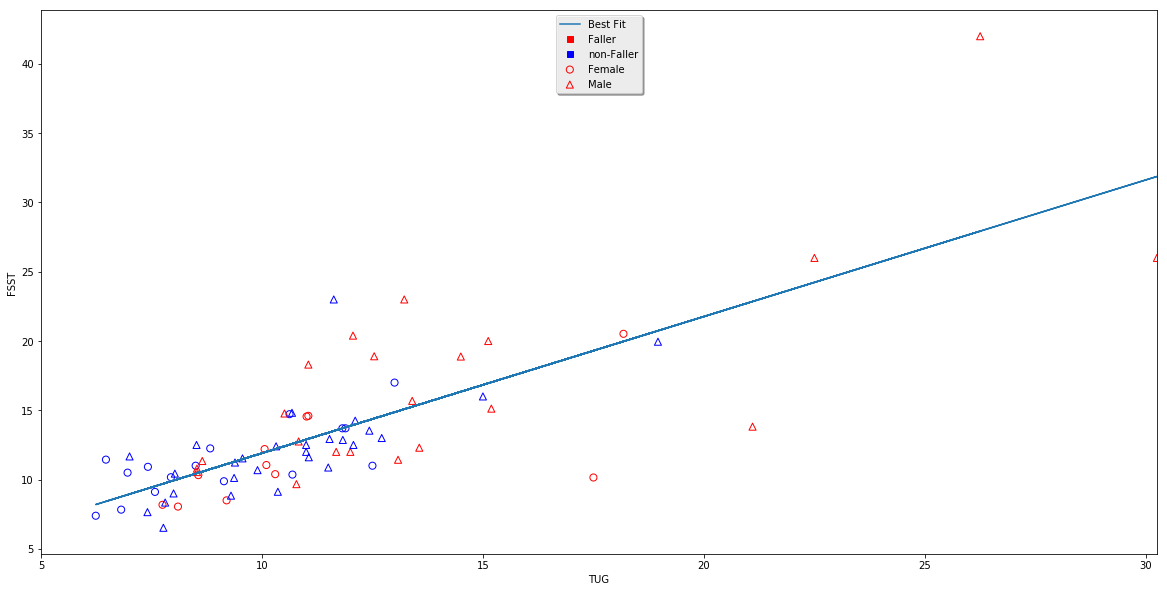

In [26]:
# note that the legend only has the plot labels  - the shapes and the line of best fit... the easiest way to add colour to 
# the legend is to plot another line with no points and give that a label. we'll increease the size of the markers using s=50
# too. by setting colour (abbreviated to c) to none, the markers become hollow  :

fig, ax = plt.subplots(figsize=(20,10))
# scatter plot followed by lr plot
marks = {0:'o',1:'^'}
lab=['Female','Male'] # labels for each plot - these are for the Legend 
pointgroup = {}
for val,mark in marks.items(): 
    # need to calculate the colour array as we are now splitting the dataset in 2 to allow us to assign different markers 
    col = miniDf[miniDf.Gender==val].faller.map(lambda x: 'blue' if x==0 else 'red')
    pointgroup[val] = miniDf[miniDf.Gender==val].plot.scatter(x='TUG',y='FSST',ax=ax,marker=mark,s=50,
              c='none',edgecolors=col,label=lab[val])
# plt.scatter([], [], ' ', label="Extra label on the legend")


lr.plot.line(x='rx',y='ry',ax=ax,label='Best Fit')


plt.plot([],[],' ',label='Faller',marker = 's',c='red') # dummy line for legend 
plt.plot([],[],' ',label='non-Faller',marker = 's',c='blue') # dummy line for legend 
#plt.plot()

#plt.legend(handles=[red_patch],axes=ax)
legend = ax.legend(loc='upper center', shadow=True)
ax.set_xlim([5,lr.rx.max()])
ax.set_xlabel('TUG')


Moving on to 3D plots - use the scaled version of the data attempting to predict fallers vs non-fallers .. need to use a new notepbook as the %matplotlib inline means we get static images rather than interactive  

In [ ]:
#%% perhaps kmeans will be prettier  http://stamfordresearch.com/k-means-clustering-in-python/
from sklearn.cluster import KMeans
import sklearn.metrics as sm
# give kmeans all the data except fallers and see what it does .. we want 2 nice clusters please 
model = KMeans(n_clusters=2)
x=miniDf.copy().drop('faller',axis=1)
model.fit(x)
y=miniDf.faller.values
y = y.astype(int)
model.labels_

# create array with mismatches  - make predictions 2/4 instead of 0/1
mism = (model.labels_)*2 + y
# now 2 = matched 0-0 (non-faller), 1 = mismatched faller, 2 = mismatched non-faller, 3 = matched faller
# by matched here, we mean prediction and truth match 
mism = mism.astype(int)

 
# Create a colormap
colormap = np.array(['red', 'purple','grey','blue']) # red and blue ok 
fig = plt.figure(figsize=(14,7)) 
# Plot the Original Classifications
ax1 =plt.subplot(1, 3, 1) # 1 row, 3 cols , this is the first plot 
plt.scatter(x.BERG, x.TUG, c=colormap[y], s=40)
plt.title('Real Classification')
 
# Plot the Models Classifications
ax2 = plt.subplot(1, 3, 2)
plt.scatter(x.BERG, x.TUG, c=colormap[model.labels_], s=20)
plt.title('K Mean Classification')
# Plot the Models Classifications
ax3 = plt.subplot(1, 3, 3)
plt.scatter(x.BERG, x.TUG, c=colormap[mism], s=20)
plt.title('K Mean Classification errors in purple (faller) and grey (non-faller)')


In [ ]:

# lets plot them on 3d axes with age thrown in , just to get some 
# separation 
#%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(20,10)) # get a figure
ax = fig.add_subplot(111, projection='3d') # add some 3d axes 
#plt.xlim(0.5,1)
#plt.ylim(0.5,1) 
a = ax.scatter(x.BERG, x.TUG, x.Age, c=colormap[mism], s=20,label='all') 
# we seem to have a lot more purple than grey - can't rember what they are , so we'll add a legend 
# create legends 
# approach here is to create one plot for all points , regardless of colour. Alternative is to plot each colour
# separately ... then the legend becomes easier asyou can assign the label in the ax.scatter function
import matplotlib.patches as mpatches # allows us to create polygons of colour 

classes = ['non-faller','mismatched faller','mismatched non-faller', 'non-faller']

recs = []
legend = ax.legend(loc='upper center', shadow=True)

for i in range(0,len(colormap)):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=colormap[i])) # fc = facecolor
plt.legend(recs,classes,loc=4)
# add axis labels too:
plt.xlabel('BERG')  # like this   
ax.set_ylabel('TUG') # or this 
ax.set_zlabel('Age') 

# lets focus on the bottom right - there seemsto be a bug in matplotlib 3d at the moment 
#ax.set_xlim(0,1)
#ax.set_ylim(0,1) leave til later 